In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

import tqdm  # progress bars
import time

DATA_ROOT = '/tmp/data'

In [2]:
transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


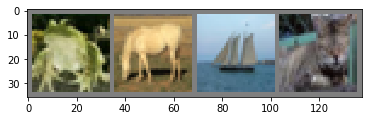

Train Size: 12500
Test Size: 2500
Image Size: torch.Size([3, 32, 32])


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Train Size:', len(trainloader))
print('Test Size:', len(testloader))
print('Image Size:', images[0].size())

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0

100%|██████████| 12500/12500 [01:20<00:00, 154.96it/s]

Epoch 1


100%|██████████| 12500/12500 [01:24<00:00, 147.28it/s]


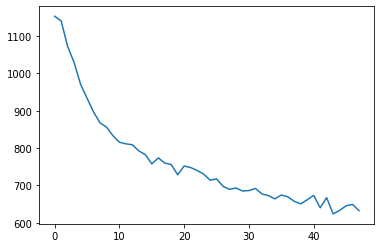

In [5]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
history = list()
update_n = 500

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
net.to(device)

for epoch in range(2):
    loss_acum = 0.0
    print('Epoch', epoch, end='', flush=True)
    
    for i,data in enumerate(tqdm.tqdm(trainloader)):
        optimizer.zero_grad()
        input = data[0].to(device)
        target = data[1].to(device)
        
        out = net(input)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        loss_acum += loss
        if i%update_n == 0 and i!=0:
            # print('[%d, %d] Loss=%f' % (epoch,i,loss_acum/update_n))
            history.append(loss_acum)
            loss_acum=0.0

plt.plot(history)

In [6]:
# ENABLE IF ANCDATA ERROR
# Increase number if still ancdata error
if True:
    import resource
    rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
    resource.setrlimit(resource.RLIMIT_NOFILE, (2048*4, rlimit[1]))

total = 0
correct = 0
incorrects = {'num': [], 'image': [], 'prediction': [], 'label': []}

with torch.no_grad():
    for i,data in enumerate(tqdm.tqdm(testloader)):
        input, label = data[0].to(device), data[1].to(device)
        outputs = net(input)
        _, predicted = torch.max(outputs.data, 1)
        
        for j,_ in enumerate(label):
            total += 1
            if predicted[j] == label[j]:
                correct +=1
            else:
                incorrects['num'].append(i*4 + j)
                incorrects['image'].append(input[j])
                incorrects['prediction'].append(predicted[j])
                incorrects['label'].append(label[j])

print('Global Accuracy:',correct/total)

100%|██████████| 2500/2500 [00:07<00:00, 316.12it/s]

Global Accuracy: 0.5465


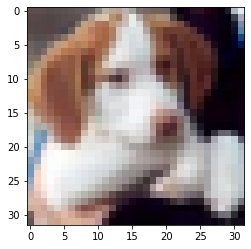

Label: dog
Predicted: cat


In [16]:
pick = 5

imshow(torchvision.utils.make_grid(incorrects['image'][pick]))
print('Label:', classes[incorrects['label'][pick].data])
print('Predicted:', classes[incorrects['prediction'][pick].data])